In [1]:
pwd

'/data2/mito_lineage/src/vireo'

In [2]:
INDIR="/data2/mito_lineage/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_mgatkdonor/vireo/nclones20"
COUNT_INDIR="/data2/mito_lineage/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_mgatkdonor/vireo/donor0/mgatk_donor/"
OUTDIR= "/data2/mito_lineage/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_mgatkdonor/vireo/nclones20/clones_dendro/"
#N_DONORS=4
DONOR=0
#INDIR=""
sample_names="Control,Flt3l" #"Control,Flt3l,Input"

In [3]:
from src.utils.data_io import setup_outdir
#setup_outdir(OUTDIR, dirs=('figures'))

fig_utils from mplh


In [4]:
sample_names = {ind:val for ind,val in enumerate(sample_names.split(","))}


In [5]:
from os.path import join, exists, dirname
from glob import glob
import pickle
import mplh.cluster_help as ch
import mplh.fig_utils as fu

import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)

import pandas as pd
import seaborn as sns
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

0.5.6


In [6]:
def filt_high(df, thresh):
    return df.loc[(df.mean(axis=1)<thresh)].index.values


# Using vireo for clonal reconstruction - mitochondrial mutations

The mitochondrial mutations data set is extracted from [Ludwig et al, Cell, 2019](https://doi.org/10.1016/j.cell.2019.01.022), the 9 variants used here are from Supp Fig. 2F (and main Fig. 2F).

For clonal reconstruction, we are using the core class `vireoSNP.Vireo` with multiple initializations

## Load cluster results and plot dendrograms

In [7]:
import seaborn as sns
from mplh import cluster_help as ch

In [8]:
out_f = join(OUTDIR, f"donor{DONOR}_clones_meanAF_dendrogram")

curr_ad_f = join(COUNT_INDIR, "cellSNP.tag.AD.mtx")
curr_dp_f = join(COUNT_INDIR, "cellSNP.tag.DP.mtx")
print(curr_ad_f)
print(curr_dp_f)


/data2/mito_lineage/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_mgatkdonor/vireo/donor0/mgatk_donor/cellSNP.tag.AD.mtx
/data2/mito_lineage/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_mgatkdonor/vireo/donor0/mgatk_donor/cellSNP.tag.DP.mtx


In [9]:
#for n in range(N_DONORS):

curr_ad = mmread(curr_ad_f).tocsc()
curr_dp = mmread(curr_dp_f).tocsc()
AD_df = pd.DataFrame(curr_ad.todense())
AD_df.index.name = "Variant"
AD_df.columns.name = "Cell"
DP_df = pd.DataFrame(curr_dp.todense())
DP_df.index.name = "Variant"
DP_df.columns.name = "Cell"
AF_df = AD_df/(DP_df+0.001)
#AD_df = pd.merge(AD_df, vcf[["#CHROM", "POS", "ALT"]], how="inner", left_index=True,right_index=True).set_index(["#CHROM", "POS", "ALT"])


In [10]:
cells_meta = pd.read_csv(join(INDIR, "cells_meta.tsv"), sep='\t').sort_values(["donor", "donor_index", 
                                                                               "lineage", "lineage_index"])
cells_meta
curr_labels = cells_meta[cells_meta["donor"]==DONOR]
colors={val[0]:val[1] for val in zip(sample_names, sns.color_palette('Set2', len(sample_names)))}
curr_labels["Color"] = curr_labels["condition"].map(colors)

/home/isshamie/miniconda3/envs/mttrace/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
curr_labels = curr_labels.reset_index()
curr_labels["old_donor_index"] = curr_labels["donor_index"]
curr_labels["donor_index"] = curr_labels.index
#curr_labels = curr_labels.sort_values('donor_index').set_index("donor_index").reindex().reset_index()
curr_labels

,level_0,index,ID,raw ID,new index,condition,donor,donor_index,lineage,lineage_index,Color,old_donor_index
0,803,2,AAACGAAAGTCGTGAG-1_Control,AAACGAAAGTCGTGAG-1,3,Control,0,0,12.0,1.0,NaN,1
1,1335,4,AAACGAACACAATAAG-1_Control,AAACGAACACAATAAG-1,5,Control,0,1,18.0,1.0,NaN,2
2,1630,9,AAACGAAGTAAGTCTC-1_Control,AAACGAAGTAAGTCTC-1,10,Control,0,2,NaN,NaN,NaN,3
3,1631,12,AAACGAAGTGGATTCT-1_Control,AAACGAAGTGGATTCT-1,13,Control,0,3,NaN,NaN,NaN,4
4,1632,14,AAACGAATCGCAACTA-1_Control,AAACGAATCGCAACTA-1,15,Control,0,4,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...
4195,4197,17387,TTTGTGTCACGCCGAT-1_Flt3l,TTTGTGTCACGCCGAT-1,17388,Flt3l,0,4195,NaN,NaN,NaN,4201
4196,4198,17388,TTTGTGTCACTACACA-1_Flt3l,TTTGTGTCACTACACA-1,17389,Flt3l,0,4196,NaN,NaN,NaN,4202
4197,4199,17392,TTTGTGTGTATACGCT-1_Flt3l,TTTGTGTGTATACGCT-1,17393,Flt3l,0,4197,NaN,NaN,NaN,4203
4198,1629,17393,TTTGTGTGTATCTCAG-1_Flt3l,TTTGTGTGTATCTCAG-1,17394,Flt3l,0,4198,19.0,161.0,NaN,4204


In [12]:
def calc_mean(cells, af):
    #print(cells.head())
    #print('cells')
    #print(cells.tail(n=100))
    print(cells.shape)
    return af.iloc[:, (cells['donor_index']).values-1].mean(axis=1)
    

In [13]:
TO_SAVE_FIG=False

(13, 12)
(15, 12)
(96, 12)
(141, 12)
(22, 12)
(29, 12)
(2, 12)
(10, 12)
(2, 12)
(15, 12)
(2, 12)
(3, 12)
(58, 12)
(99, 12)
(26, 12)
(45, 12)
(1, 12)
(2, 12)
(19, 12)
(34, 12)
(59, 12)
(110, 12)
(92, 12)
(113, 12)
(51, 12)
(113, 12)
(1, 12)
(3, 12)
(3, 12)
(41, 12)
(83, 12)
(14, 12)
(18, 12)
(51, 12)
(83, 12)
(63, 12)
(98, 12)
(13, 12)
(15, 12)
(96, 12)
(141, 12)
(22, 12)
(29, 12)
(2, 12)
(10, 12)
(2, 12)
(15, 12)
(2, 12)
(3, 12)
(58, 12)
(99, 12)
(26, 12)
(45, 12)
(1, 12)
(2, 12)
(19, 12)
(34, 12)
(59, 12)
(110, 12)
(92, 12)
(113, 12)
(51, 12)
(113, 12)
(1, 12)
(3, 12)
(3, 12)
(41, 12)
(83, 12)
(14, 12)
(18, 12)
(51, 12)
(83, 12)
(63, 12)
(98, 12)
(1004, 12)
(1566, 12)
(1004, 12)
(1566, 12)
clustering
cmap None


No handles with labels found to put in legend.


clustering
cmap None
clustering
cmap None


No handles with labels found to put in legend.


clustering
cmap None
clustering
cmap None


No handles with labels found to put in legend.


clustering
cmap None
clustering
cmap None


No handles with labels found to put in legend.


clustering
cmap None


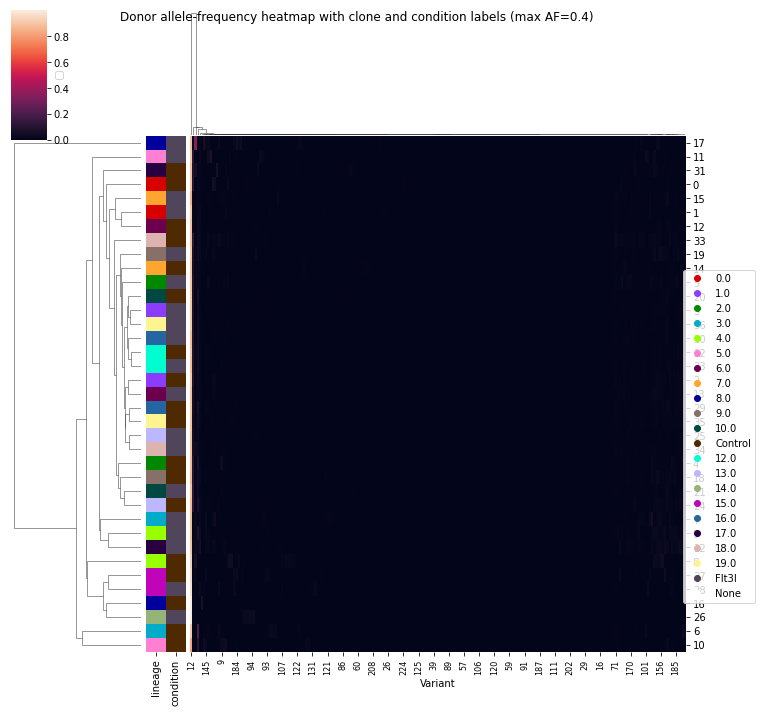

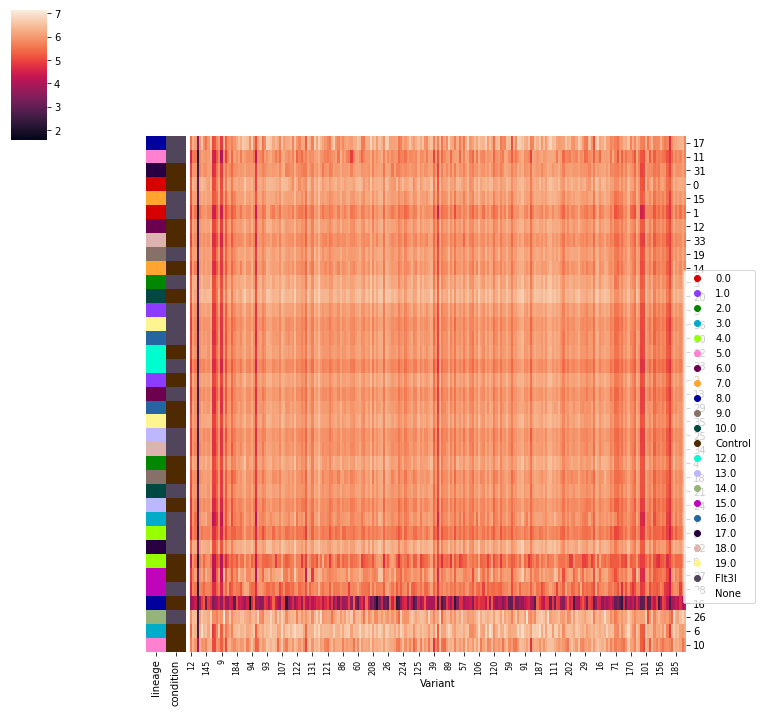

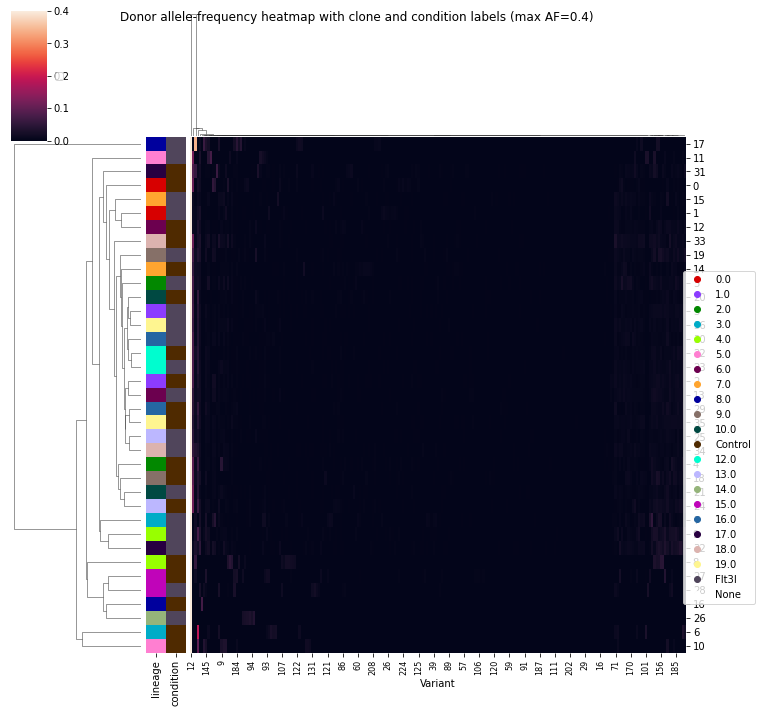

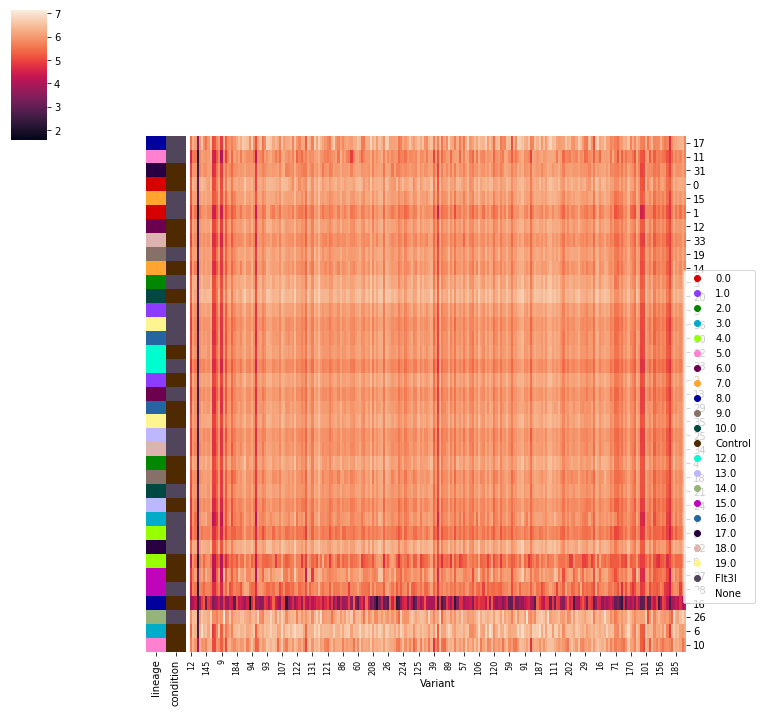

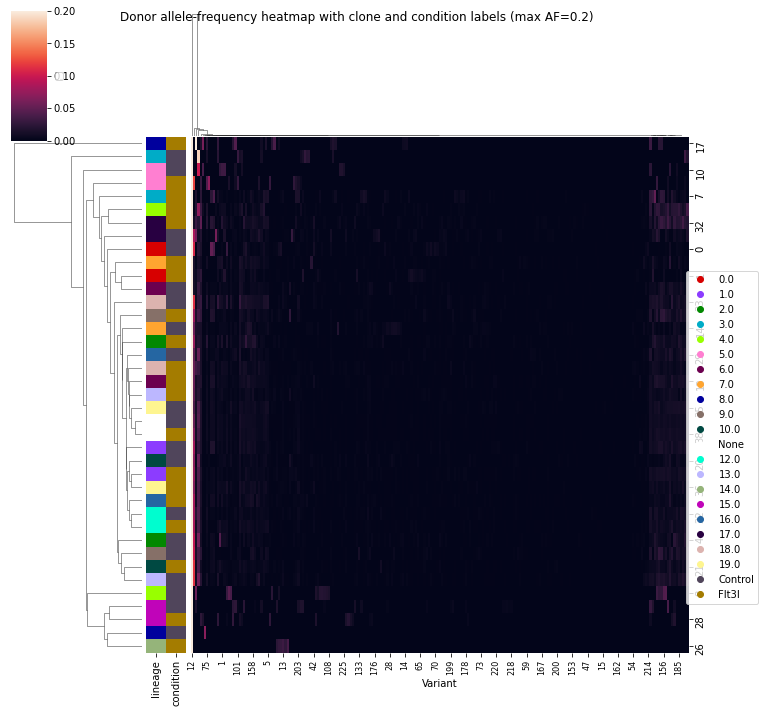

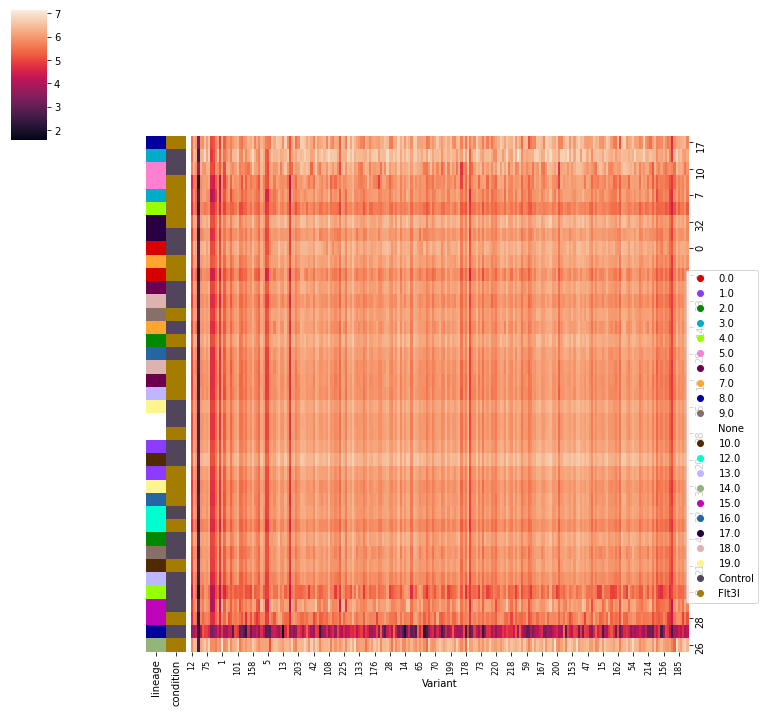

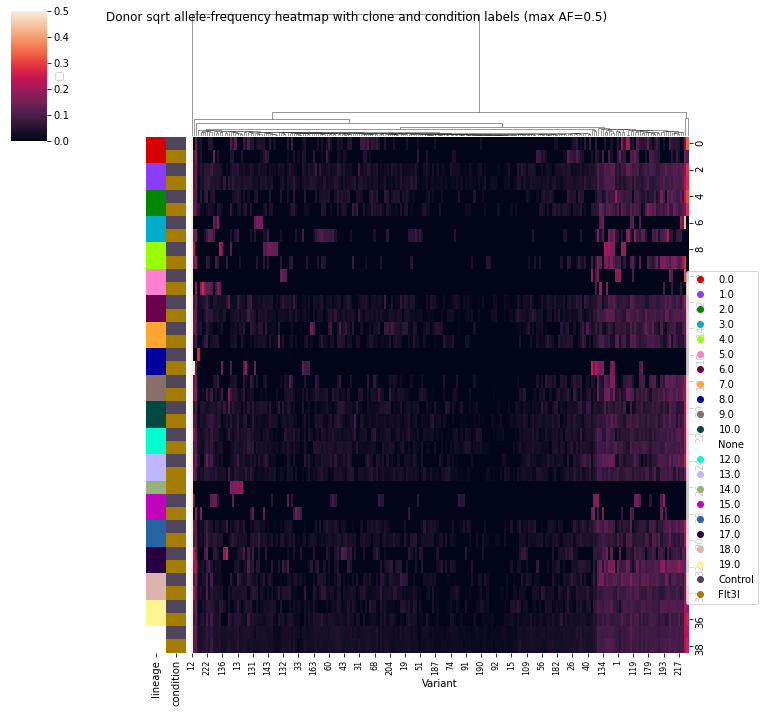

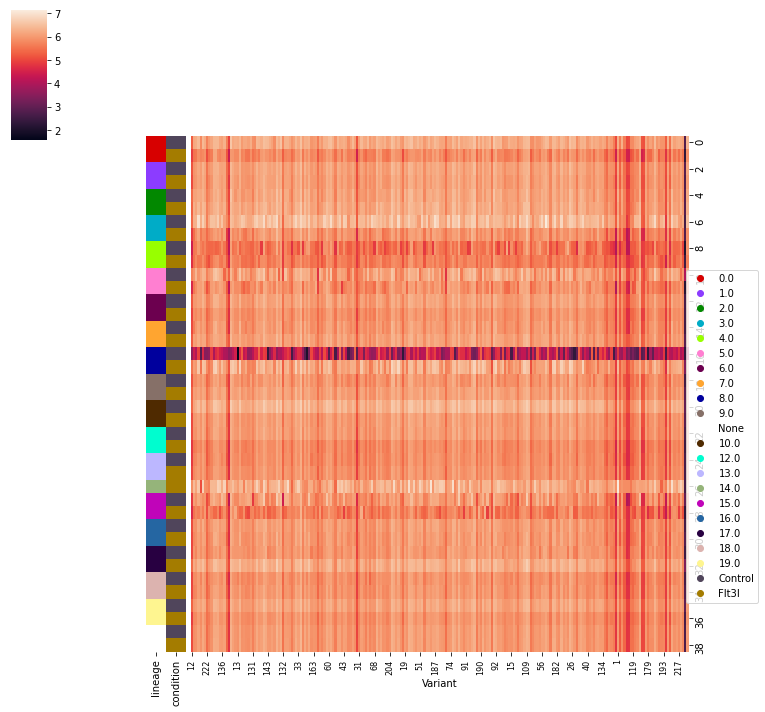

In [14]:
mean_af = curr_labels.groupby(["lineage", "condition"]).apply(calc_mean, af=AF_df)
anno = mean_af.reset_index()[["lineage", "condition"]]

#mean_dp = curr_labels.groupby(["lineage", "condition"]).apply(calc_mean, af=nlog2(DP_df))
mean_dp = curr_labels.groupby(["lineage", "condition"]).apply(calc_mean, af=np.log2(DP_df+1))
anno_dp = mean_dp.reset_index()[["lineage", "condition"]]
mean_dp = mean_dp.reset_index(drop=True)

na_cells = curr_labels.loc[curr_labels["lineage"].isnull()]
na_mean_af = na_cells.groupby("condition").apply(calc_mean, af=AF_df)

na_mean_af
na_anno = pd.concat((anno,pd.DataFrame({"lineage":["None", "None"], "condition":na_mean_af.index})), ignore_index=True)
na_concat = pd.concat((mean_af.reset_index(drop=True), na_mean_af.reset_index(drop=True)), ignore_index=True)

na_mean_dp = na_cells.groupby("condition").apply(calc_mean, af=np.log2(DP_df+1))
na_dp_concat = pd.concat((mean_dp, na_mean_dp.reset_index(drop=True)), ignore_index=True)


################
## Plotting
################
## 1.
g1 = ch.plot_cluster((mean_af.reset_index(drop=True)), row_meta=anno, #curr_labels[["condition", "lineage"]], 
                    to_row_clust=True, to_col_clust=True)
g1.figure.suptitle("Donor allele-frequency heatmap with clone and condition labels (max AF=0.4)")
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
fu.helper_save(out_f+".raw.clust.AF.png", f=g1.figure)

inds = g1.dendrogram_row.dendrogram["leaves"]
cols = g1.dendrogram_col.dendrogram["leaves"]
g1d = ch.plot_cluster(mean_dp.iloc[inds, cols], to_row_clust=False, to_col_clust=False, 
                        row_meta=anno_dp.iloc[inds])
fu.helper_save(out_f+".raw.clust.DP.png", f=g1d.figure, to_pdf=False)


# ## 2.
g2 = ch.plot_cluster((mean_af.reset_index(drop=True)), row_meta=anno, #curr_labels[["condition", "lineage"]], 
                    to_row_clust=True, to_col_clust=True, vmax=0.4, vmin=0)
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
g2.figure.suptitle("Donor allele-frequency heatmap with clone and condition labels (max AF=0.4)")
fu.helper_save(out_f+".raw.clust.max4.AF.png")
inds = g2.dendrogram_row.dendrogram["leaves"]
cols = g2.dendrogram_col.dendrogram["leaves"]
ch.plot_cluster(mean_dp.iloc[inds,cols], to_row_clust=False, to_col_clust=False, 
                        row_meta=anno_dp.iloc[inds])
fu.helper_save(out_f+".raw.clust.max4.DP.png", to_pdf=False)


## 3.
g = ch.plot_cluster(na_concat, row_meta=na_anno, #curr_labels[["condition", "lineage"]], 
                    to_row_clust=True, to_col_clust=True, vmax=0.2, vmin=0)
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
plt.suptitle("Donor allele-frequency heatmap with clone and condition labels (max AF=0.2)")
fu.helper_save(out_f+".na.clust.max2.AF.png")

inds = g.dendrogram_row.dendrogram["leaves"]
cols = g.dendrogram_col.dendrogram["leaves"]
ch.plot_cluster(na_dp_concat.iloc[inds,cols], to_row_clust=False, to_col_clust=False, 
                        row_meta=na_anno.iloc[inds])
fu.helper_save(out_f+".na.clust.max2.DP.png", to_pdf=False)


# ## 4.
g = ch.plot_cluster(np.sqrt(na_concat), row_meta=na_anno, #curr_labels[["condition", "lineage"]], 
                    to_row_clust=False, to_col_clust=True, vmax=0.5, vmin=0)
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
plt.suptitle("Donor sqrt allele-frequency heatmap with clone and condition labels (max AF=0.5)")
fu.helper_save(out_f+".na.max5.AF.png")
#inds = g.dendrogram_row.dendrogram["leaves"]
cols = g.dendrogram_col.dendrogram["leaves"]
ch.plot_cluster(na_dp_concat.iloc[:,cols], to_row_clust=False, to_col_clust=False, 
                        row_meta=na_anno.iloc[inds])
fu.helper_save(out_f+".na.clust.max5.DP.png", to_pdf=False)

#plt.close('all')

## Get variants and types of variants